In [7]:
from collections import Counter, deque
import random
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
from fractions import Fraction
import numpy as np
import scipy as sp
import scipy.linalg as la

In [8]:

board = """GO   R1 Car R2  R3 R4 R5  DiagonAlley R7 ZombieVines
           Swamp R8 R9  R10  R11 R12 Car  GarlicGarden R13 R14 
           DiagonAlley   R16 R17 R18  Swamp R19 R20  ZombieVines  R21 Car 
           R22  R23 DiagonAlley  R25 R26 R27 R28 Swamp  GarlicGarden R29""".split()
board

['GO',
 'R1',
 'Car',
 'R2',
 'R3',
 'R4',
 'R5',
 'DiagonAlley',
 'R7',
 'ZombieVines',
 'Swamp',
 'R8',
 'R9',
 'R10',
 'R11',
 'R12',
 'Car',
 'GarlicGarden',
 'R13',
 'R14',
 'DiagonAlley',
 'R16',
 'R17',
 'R18',
 'Swamp',
 'R19',
 'R20',
 'ZombieVines',
 'R21',
 'Car',
 'R22',
 'R23',
 'DiagonAlley',
 'R25',
 'R26',
 'R27',
 'R28',
 'Swamp',
 'GarlicGarden',
 'R29']

In [9]:
def list_duplicates_of(seq,item):
    start_at = -1
    locs = []
    while True:
        try:
            loc = seq.index(item,start_at+1)
        except ValueError:
            break
        else:
            locs.append(loc)
            start_at = loc
    return locs

In [10]:
cars_i = list_duplicates_of(board,'Car')
cars_i
board[31]

'R23'

In [11]:

def IOB(steps):
    """Simulate given number of steps of Monopoly game, 
    yielding the number of the current square after each step."""
    goto(0) # start at GO
    cars_i = list_duplicates_of(board,'Car')
    dieset = [1,2,3,4,'Gun','Med']
    for _ in range(steps):
        die = random.choice(dieset) # roll die
        if isinstance(die, int):
            goto(here + die)  # here is a global variable, so gets initialized to 0. It's modulo-40
        else:
            goto(here)
        if (board[here] == 'Car'):
            goto(here + 2)
        elif (board[here] == 'Swamp'):
            goto(here)
        yield here  # yield ensures IOB() returns a *list* of positions. Also, allows to resume where we left off       

def goto(cell):
    "Update the global variable 'here' to be certain cell."
    global here
    here = cell % len(board)

In [12]:
results = list(IOB(400000))

In [277]:

pd.DataFrame(results[0:100]).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3,6,9,12,18,18,19,20,20,24,...,23,26,26,28,28,31,33,33,35,35


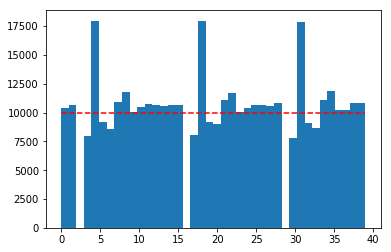

In [278]:

plt.hist(results, bins=40)
avg = len(results) / 40
plt.plot([0, 39], [avg, avg], 'r--');

In [279]:
board[4]

'R3'

In [280]:

def P(pred, dst): 
    "Proba that pred is true, given the dst pdf"
    return sum(dst[e] for e in dst if pred(e))

class ProbabilityDistribution(dict):
    "A Probability Distribution; an {outcome: probability} mapping where probabilities sum to 1."
    def __init__(self, mapping=(), **kwargs):
        self.update(mapping, **kwargs)
        total = sum(self.values())
        if isinstance(total, int): 
            total = Fraction(total, 1)
        for key in self: # Make probabilities sum to 1.
            self[key] = self[key] / total
            
    def __and__(self, pred): # Call this method by writing ProbabilityDistribution & predicate
        "New ProbabilityDistribution, for outcomes of this ProbabilityDistribution for which pred is true."
        return ProbabilityDistribution({e:self[e] for e in self if pred(e)})

def Uniform(out): return ProbabilityDistribution({e: 1 for e in out})

def joint(X, Y, sep=''):
    "joint pdf of two independent pdfs. Entries of the shape {x+sep+y: P(x)*P(y)}"
    return ProbabilityDistribution({x + sep + y: X[x] * Y[y]
                    for x in X
                    for y in Y})

In [281]:
probD = ProbabilityDistribution(Counter(board[i] for i in results))
probD

{'R2': Fraction(7993, 400000),
 'R5': Fraction(4303, 200000),
 'ZombieVines': Fraction(20617, 400000),
 'R9': Fraction(10673, 400000),
 'R13': Fraction(8971, 200000),
 'R14': Fraction(9201, 400000),
 'DiagonAlley': Fraction(5817, 80000),
 'Swamp': Fraction(31061, 400000),
 'R21': Fraction(5417, 200000),
 'R23': Fraction(8931, 200000),
 'R27': Fraction(11867, 400000),
 'R28': Fraction(10221, 400000),
 'R29': Fraction(543, 20000),
 'GO': Fraction(2079, 80000),
 'R3': Fraction(17971, 400000),
 'R7': Fraction(11809, 400000),
 'R8': Fraction(10729, 400000),
 'R10': Fraction(1323, 50000),
 'R18': Fraction(201, 8000),
 'R19': Fraction(10657, 400000),
 'R20': Fraction(5321, 200000),
 'R22': Fraction(7817, 400000),
 'R12': Fraction(10691, 400000),
 'R17': Fraction(11667, 400000),
 'R11': Fraction(5349, 200000),
 'GarlicGarden': Fraction(9441, 200000),
 'R26': Fraction(1107, 40000),
 'R16': Fraction(11087, 400000),
 'R25': Fraction(2161, 100000),
 'R1': Fraction(5313, 200000),
 'R4': Fraction(91

Probability of landing on each cell on the game board, notice that player has the most probability of landing on cell 13, 14 (Road 10 & 11) 

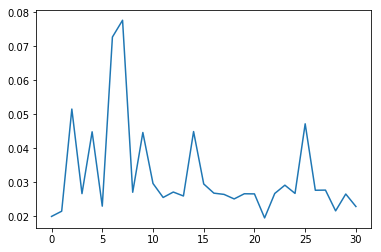

In [282]:
v = [];
for f in probD.values():
    v.append(float(f))
v
plt.plot(v)

Compute the regular transition matrix.

In [283]:
regular = np.zeros((40,40))

In [284]:
dieroll_distance = np.zeros(40)

In [285]:
rolls = [2, 1, 1, 1, 1]
for index, r in enumerate(rolls):
    dieroll_distance[index] = r
dieroll_distance /= 6
print(dieroll_distance)

[0.33333333 0.16666667 0.16666667 0.16666667 0.16666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


In [286]:
for row in range(40):
    regular[row] = np.roll(dieroll_distance, row)
pd.DataFrame(regular)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Compute the special transition matrix that takes Car and Swamp cells into consideration


In [287]:
special = np.zeros((40,40))

In [288]:
swamps_i = list_duplicates_of(board,'Swamp')
diagonalleys_i = list_duplicates_of(board,'DiagonAlley')
for c in range(40):
    if c in cars_i:
        special[c,c+3] = 1.0
    elif c in swamps_i:
        special[c,c] = 1
    elif c in diagonalleys_i:
        special[c,c+1] = 1/2
        special[c,c] = 1/2
    else:
        special[c, c] = 1.0
pd.DataFrame(special)

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [289]:
transition = regular @ special
pd.DataFrame(transition)


,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.333333,0.166667,0.0,0.166667,0.166667,0.166667,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.333333,0.0,0.166667,0.166667,0.333333,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.0,0.166667,0.166667,0.500000,0.166667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.333333,0.166667,0.166667,0.166667,0.083333,0.083333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.333333,0.166667,0.166667,0.083333,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.166667,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.083333,0.250000,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.166667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [290]:
for i in range(40):
    print(np.sum(transition[i]))

1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
0.9999999999999999
0.9999999999999999
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
0.9999999999999999
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0


In [291]:
w, v = la.eig(transition)

In [292]:
v

array([[ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10359668+0.j, -0.0017282 +0.j, -0.09247645+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05049524+0.j, -0.01206354+0.j,  0.1494406 +0.j],
       [ 1.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.04602043+0.j, -0.20672447+0.j,  0.21233705+0.j],
       ...,
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
        -0.10362264+0.j, -0.04506818+0.j,  0.31940017+0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.05054715+0.j,  0.0250717 +0.j, -0.0875339 +0.j],
       [ 0.        +0.j,  0.        +0.j,  0.        +0.j, ...,
         0.07163524+0.j,  0.00951672+0.j, -0.08608212+0.j]])

In [293]:
w2, v2 = la.eig(transition)
w2

array([0.        +0.j        , 0.        +0.j        ,
       0.        +0.j        , 1.        +0.j        ,
       0.92405005+0.27725517j, 0.92405005-0.27725517j,
       0.72615653+0.46896933j, 0.72615653-0.46896933j,
       0.48033756+0.52880989j, 0.48033756-0.52880989j,
       0.26670566+0.46582709j, 0.26670566-0.46582709j,
       0.13737449+0.32984116j, 0.13737449-0.32984116j,
       0.1010537 +0.18796469j, 0.1010537 -0.18796469j,
       0.32735151+0.11504644j, 0.32735151-0.11504644j,
       0.26098497+0.14248803j, 0.26098497-0.14248803j,
       0.35607121+0.05120042j, 0.35607121-0.05120042j,
       0.18554501+0.11837991j, 0.18554501-0.11837991j,
       0.1141502 +0.07607977j, 0.1141502 -0.07607977j,
       0.13293198+0.05130043j, 0.13293198-0.05130043j,
       0.32615857+0.00979771j, 0.32615857-0.00979771j,
       0.14534688+0.00549574j, 0.14534688-0.00549574j,
       0.16666667+0.j        , 0.2664358 +0.0483954j ,
       0.2664358 -0.0483954j , 0.20712339+0.00929276j,
       0.2

Dominant eigenvector

In [294]:
v[0]

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -1.58113883e-01+0.j        ,
        1.62138892e-02-0.15764873j,  1.62138892e-02+0.15764873j,
       -1.56405334e-01-0.03044961j, -1.56405334e-01+0.03044961j,
       -6.93831031e-02+0.1439574j , -6.93831031e-02-0.1439574j ,
        5.79851774e-04-0.1577264j ,  5.79851774e-04+0.1577264j ,
       -8.05907039e-02-0.12519606j, -8.05907039e-02+0.12519606j,
       -1.26305180e-01+0.02716807j, -1.26305180e-01-0.02716807j,
       -1.07645809e-01+0.11697275j, -1.07645809e-01-0.11697275j,
        9.36494762e-02+0.09386854j,  9.36494762e-02-0.09386854j,
        5.95916525e-02-0.16390996j,  5.95916525e-02+0.16390996j,
        5.59403640e-02-0.08223099j,  5.59403640e-02+0.08223099j,
       -5.78447895e-02+0.08070199j, -5.78447895e-02-0.08070199j,
       -4.34355702e-02+0.01345344j, -4.34355702e-02-0.01345344j,
       -1.64714281e-01-0.02697405j, -1.64714281e-01+0.02697405j,
        1.22096247e-02+0.

Construct object-oriented program for the IOB game


In [51]:
NUM_CELLS = 40
dieset = [1,2,3,4,'Gun','Med']

Zombies object

In [111]:
class Zombies(object):
    
    def __init__(self, game):
        self.v_zombies = 2
        self.power = 5
        self.position = 0
        self.round = 1
        self.turn = 0
        self.game = game
        self.shot = False
        
    def goto_action(self, pass_go = True, isNight = False):
        move = True
        bite = False
        if self.shot == True:
            return False
        if pass_go:
            closest = self.v_zombies
            for p in self.game.players:
                if p.position - self.position < closest:
                    closest = p.position - self.position
            if self.position + closest == self.position:
                move = False
            self.position = self.position + closest
            print('zombies() position: ',self.position)
            self.turn += 1
            print('list at Zombies() position: ',game.gameBoard[self.position])
            if game.boardTemplate[self.position] != 'GarlicGarden':
                for x in game.gameBoard[self.position]:
                    if isinstance(x,Player):
                        print('bite?')
                        bite = True
                        x.hp = x.hp - self.power
                        
        print('zombies move?', move)
        return move, bite

Player object

In [53]:
a = 99
gunshot = True
a = True if gunshot else False

a = [p,1]
for i in range(2):
    print(i)

NameError: name 'p' is not defined

In [86]:
class Player(object):
    
    def __init__(self, playerNum, game):
        self.playerNum = playerNum
        self.game = game
        self.position = 0
        self.turn = 0
        self.round = 1
        self.score = 0
        self.hp = 100
        
    def roll_dice(self):
        die = random.choice(dieset)
        return die
    def goto_action(self,die,pass_go = True):
        self.turn += 1
        gunshot = False
        new_round = False
        isDrive = False
        self.die = die
        if isinstance(die, int):
            
            self.position += die
            
        elif die == 'Gun':
            for l in self.game.gameBoard[self.position-2:self.position+1]:
                for x in l:
                    if isinstance(x, Zombies):
                        self.score += 2
                        gunshot = True
                        break
        else:
            if self.hp != 100:
                self.hp  = (100 if self.hp + 5 > 100 else self.hp + 5)
        
        if self.position >= NUM_CELLS:
                self.position = self.position % NUM_CELLS
                self.round += 1
                new_round = True
        
        print('??????????',self.game.boardTemplate[self.position])
        if self.game.boardTemplate[self.position] == 'Car':
            isDrive = True
            print('drive car??????????')
            self.position += 2
        return new_round, self.position, gunshot, isDrive
        

Create game board based on the board template created at the very begining 

In [112]:
class Game():
    def __init__(self, numPlayers):
        self.gameBoard = []
        for _ in range(NUM_CELLS):
            self.gameBoard.append([None])
        self.boardTemplate = """GO   R1 Car R2  R3 R4 R5  DiagonAlley R7 ZombieVines
           Swamp R8 R9  R10  R11 R12 Car  GarlicGarden R13 R14 
           DiagonAlley   R16 R17 R18  Swamp R19 R20  ZombieVines  R21 Car 
           R22  R23 DiagonAlley  R25 R26 R27 R28 Swamp  GarlicGarden R29""".split()
        self.players = [Player(i + 1, self) for i in range(numPlayers)]
        self.gameBoard[0] = self.players.copy()
        self.zombies = Zombies(self)
        self.diagonalleyCards = ['key','loss']
        random.shuffle(self.diagonalleyCards)
        
        
        
        
        
        self.Proeperties = []
        
        
        
        
        
        
    def playIOB(self, num_rolls):
        day_cnt = 0
        night_cnt = 0
        for r in range(num_rolls):
            
            for p in self.players:
                die = p.roll_dice()
                print('???????????????', die)
                nr, player_pos, gunshot, isDrive = p.goto_action(die)
                self.zombies.shot = True if gunshot else False
                if isinstance(die,int):
                    print('ppos: ', p.position)
                    print("Player current roll: ", die)
                    print('gameboard at ppos - die: ', self.gameBoard[p.position-die])
                    if isDrive:
                        print("!!!!!!!!!!!!!")
                        (self.gameBoard[p.position-die-2]).remove(p)
                    else:
                        (self.gameBoard[p.position-die]).remove(p)
                    if isDrive:
                        if len(self.gameBoard[p.position-die-2]) == 0:
                            self.gameBoard[p.position-die - 2].append(None)
                    else:
                        if len(self.gameBoard[p.position-die]) == 0:
                            self.gameBoard[p.position-die].append(None)
                    if self.gameBoard[p.position] == [None]:
                        self.gameBoard[p.position] = [p]
                    else:
                        self.gameBoard[p.position].append(p)
                else:
                    print('player did not move')
                new_round = nr
                print("Player current roll: ", die)
                print("Player current possition: ", p.position)
                print("Player current score: ", p.score)
                print("Player current hp: ", p.hp)
                print("Total number of rolls: ", p.turn)
                print("player round: ", p.round)
            if new_round:
                self.zombies = Zombies(self)
                for i in range(len(self.gameBoard)-1,-1,-1):
                    if isinstance(self.gameBoard[i][0],Zombies):
                        self.gameBoard[i][0] = None
                        break
            if self.players[0].position >= 4:
                print('zombies.turn',self.zombies.turn)
                if day_cnt == 5 and self.zombies.turn != 0 and night_cnt < 2:
                    self.zombies.power = 10
                    self.zombies.v_zombies = 3
                    if self.boardTemplate[self.zombies.position] == 'ZomebieVines':
                        self.zombies.goto_action(pass_go = False, isNight = True)
                    else:
                        z_prevPos = self.zombies.position
                        z_move, z_bite = self.zombies.goto_action(pass_go = True, isNight = True)
                        print('zomebies move? ', z_move)
                        if z_move:
                            self.gameBoard[z_prevPos] = [None]
                            if self.gameBoard[self.zombies.position] == [None]:
                                self.gameBoard[self.zombies.position] = [self.zombies]
                            else:
                                self.gameBoard[self.zombies.position].append(self.zombies)
                    night_cnt += 1
                    day_cnt = 0 if night_cnt == 2 else 5
                else:
                    self.zombies.power = 5
                    self.zombies.v_zombies = 2
                    if self.boardTemplate[self.zombies.position] == 'ZomebieVines':
                        self.zombies.goto_action(pass_go = False, isNight = False)
                    else:
                        z_prevPos = self.zombies.position
                        z_move, z_bite = self.zombies.goto_action(pass_go = True, isNight = False)
                        print('zomebies move? ', z_move)
                        if z_move:
                            self.gameBoard[z_prevPos] = [None]
                            if self.gameBoard[self.zombies.position] == [None]:
                                print('overwrite?')
                                self.gameBoard[self.zombies.position] = [self.zombies]
                            else:
                                print('append?')
                                self.gameBoard[self.zombies.position].append(self.zombies)
                    day_cnt += 1
                    night_cnt = 0
                
                
                if z_bite:
                    for x in self.gameBoard[self.zombies.position]:
                        if isinstance(x, Player):
                            if x.hp<=0:
                                # col 3 is death count
                                self.Properties[self.boardTemplate[self.zombies.position]][3] += 1
                                x.hp = 100
                            # col 4 is bite count
                            self.Properties[self.boardTemplate[self.zombies.position]][4] += 1
                                
                    
            print("Night? ", day_cnt ==5)
            print('Zomebies speed and power: ', self.zombies.v_zombies, self.zombies.power)
            print("Zombies current position: ", self.zombies.position)
            print("Player current hp: ", p.hp)
            print('gameboard at ppos - die: ', self.gameBoard[p.position])
            print("Current gameboard:")
            print(game.gameBoard)
            print("---------------------------------------------------")
                
            

IndentationError: expected an indented block (<ipython-input-112-761731e89f21>, line 113)

Let's play some games!

In [108]:
game = Game(1)
game.playIOB(100)

??????????????? Gun
?????????? GO
player did not move
Player current roll:  Gun
Player current possition:  0
Player current score:  0
Player current hp:  100
Total number of rolls:  1
player round:  1
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  0
Player current hp:  100
gameboard at ppos - die:  [<__main__.Player object at 0x617dbb2e8>]
Current gameboard:
[[<__main__.Player object at 0x617dbb2e8>], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 4
?????????? R3
ppos:  4
Player current roll:  4
gameboard at ppos - die:  [<__main__.Player object at 0x617dbb2e8>]
Player current roll:  4
Player current possition:  4
Player current score

Player current score:  14
Player current hp:  40
Total number of rolls:  48
player round:  2
zombies.turn 16
zombies() position:  33
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  True
Zomebies speed and power:  2 5
Zombies current position:  33
Player current hp:  40
gameboard at ppos - die:  [<__main__.Player object at 0x617dbb2e8>]
Current gameboard:
[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x617d694a8>], [None], [<__main__.Player object at 0x617dbb2e8>], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? Gun
?????????? R27
player did not move
Player current roll:  Gun
Player current possition:  35
Player current score:  16
Player current 

[[None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [None], [<__main__.Zombies object at 0x617d6c6d8>], [<__main__.Player object at 0x617dbb2e8>], [None], [None], [None], [None], [None], [None], [None], [None]]
---------------------------------------------------
??????????????? 2
?????????? R25
ppos:  33
Player current roll:  2
gameboard at ppos - die:  [<__main__.Player object at 0x617dbb2e8>]
Player current roll:  2
Player current possition:  33
Player current score:  26
Player current hp:  10
Total number of rolls:  97
player round:  4
zombies.turn 15
zombies() position:  32
list at Zombies() position:  [None]
zombies move? True
zomebies move?  True
overwrite?
Night?  False
Zomebies speed and power:  2 5
Zombies current position:  32
Player current hp:  10
gameboard at ppos - die:  [<__main__.Player objec